# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content


First up is importing the packages. It's good practice to keep all the imports at the beginning of the code.

In [1]:
# Imports here
import pandas as pd
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn
from torch import optim
from collections import OrderedDict
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the data

Here I'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, I'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this I don't want any scaling or rotation transformations, but I'll need to resize then crop the images to the appropriate size.

The pre-trained networks I'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:

# Define transforms for the training data and testing data
## Mean and standard devations are provided in the problem which was calculated from ImageNet images. 
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=50)
testloader = torch.utils.data.DataLoader(test_data, batch_size=50)


In [4]:
## Check the transformed dataset
print("trainloader",len(trainloader))
print("validloader",len(validloader))
print("testloader", len(testloader))

trainloader 132
validloader 17
testloader 17


### Label mapping

Load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [6]:
## checkTheData
flowers_types = pd.DataFrame({'flower_type': cat_to_name})
print("Total no. of flowers types: ",(flowers_types.shape[0]))

Total no. of flowers types:  102


In [7]:
### Check the flowers types:
flowers_types.head(15).T

,1,10,100,101,102,11,12,13,14,15,16,17,18,19,2
flower_type,pink primrose,globe thistle,blanket flower,trumpet creeper,blackberry lily,snapdragon,colt's foot,king protea,spear thistle,yellow iris,globe-flower,purple coneflower,peruvian lily,balloon flower,hard-leaved pocket orchid


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.
Things to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) 
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters


In [8]:
# Load a pre-trained network
## I have decided to use vgg19
model = models.vgg19(pretrained=True)
model.name = "vgg19"
model


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:06<00:00, 83864610.28it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [9]:
## check the parameters
#for param in model.parameters():
#    print(param)

In [10]:
# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

In [11]:
# Define a classifier, using ReLU activations and dropout
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096, bias=True)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(4096, 102, bias=True)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [12]:
# Device agnostic code, automatically uses CUDA if it's enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device

In [13]:
# change to device
model.to(device);

In [14]:
# Define loss and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Define some variables
epochs = 5
print_every = 25 # Prints every 30 images out of batch of 50 images
steps = 0

In [15]:

# Calculate test_loss and accuracy
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for mm, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [16]:

# Lets Train the MOdel using backpropogation

print("Training process started .....\n")

for e in range(epochs):
    running_loss = 0
    #model.train() # Technically not necessary, setting this for good measure
    
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()

            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            print("Epoch: {}/{} | ".format(e+1, epochs),
                  "Training_Loss: {:.4f} | ".format(running_loss/print_every),
                  "Validation_Loss: {:.4f} | ".format(valid_loss/len(testloader)),
                  "Validation_Accuracy: {:.4f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            model.train()

print("\n YAY!! Model training is completed")

Training process started .....

Epoch: 1/5 |  Training_Loss: 8.2807 |  Validation_Loss: 3.1135 |  Validation_Accuracy: 0.3162
Epoch: 1/5 |  Training_Loss: 3.2196 |  Validation_Loss: 2.1051 |  Validation_Accuracy: 0.4665
Epoch: 1/5 |  Training_Loss: 2.5582 |  Validation_Loss: 1.5670 |  Validation_Accuracy: 0.6135
Epoch: 1/5 |  Training_Loss: 2.2077 |  Validation_Loss: 1.1940 |  Validation_Accuracy: 0.6834
Epoch: 1/5 |  Training_Loss: 1.9665 |  Validation_Loss: 1.0710 |  Validation_Accuracy: 0.7197
Epoch: 2/5 |  Training_Loss: 1.4091 |  Validation_Loss: 0.9683 |  Validation_Accuracy: 0.7469
Epoch: 2/5 |  Training_Loss: 1.7325 |  Validation_Loss: 0.9226 |  Validation_Accuracy: 0.7430
Epoch: 2/5 |  Training_Loss: 1.7647 |  Validation_Loss: 0.8332 |  Validation_Accuracy: 0.7766
Epoch: 2/5 |  Training_Loss: 1.6226 |  Validation_Loss: 0.8546 |  Validation_Accuracy: 0.7736
Epoch: 2/5 |  Training_Loss: 1.6899 |  Validation_Loss: 0.7168 |  Validation_Accuracy: 0.8093
Epoch: 3/5 |  Training_Loss:

## Testing the model

It's good practice to test the trained network on test data, images the network has never seen either in training or validation. This will give a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way that was done for validation.

In [17]:
# TODO: Do validation on the test set
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test images accuracy by model is: %d%%' % (100 * correct / total))

Test images accuracy by model is: 78%


## Save the checkpoint

Now that the network is trained, save the model so that can be loaded it later for making predictions.


In [18]:
# TODO: Save the checkpoint 
model.class_to_idx = train_data.class_to_idx

In [19]:
checkpoint = {'architecture': model.name,
             'classifier': model.classifier,
             'class_to_idx': model.class_to_idx,
             'state_dict': model.state_dict()}

torch.save(checkpoint, 'my_model_checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [20]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_my_checkpoint():
    """
    Loads previously saved checkpoint.
    
    """
    
    # Load previously saved file
    checkpoint = torch.load("'my_model_checkpoint.pth")
    
    # Its time to Download pretrained model
    model = models.vgg19(pretrained=True);
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters(): param.requires_grad = False
    
    # Load stuff from my_model_checkpoint
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])

    
    return model

# Inference for classification

Now writting a function to use a trained network for inference. That is, pass an image into the network and predict the class of the flower in the image. 

## Image Preprocessing

It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. so, need to convert the values. It's easiest with a Numpy array.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. Subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. we can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [21]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    import PIL
    test_image = PIL.Image.open(image)

    # Get original dimensions
    orig_width, orig_height = test_image.size
    #print("Original width of image: ", orig_width)
    #print("Original height of image: ", orig_height)

    # Find shorter size and create settings to crop shortest side to 256
    if orig_width < orig_height: resize_size=[256, 256**600]
    else: resize_size=[256**600, 256]
        
    test_image.thumbnail(size=resize_size)

    # Find pixels to crop on to create 224x224 image
    center = orig_width/4, orig_height/4
    left, top, right, bottom = center[0]-(244/2), center[1]-(244/2), center[0]+(244/2), center[1]+(244/2)
    test_image = test_image.crop((left, top, right, bottom))

    # Converrt to numpy - 244x244 image w/ 3 channels (RGB)
    np_image = np.array(test_image)/255 # Divided by 255 because imshow() expects integers (0:1)!!

    # Normalize each color channel based on provided means and stds
    normalise_means = [0.485, 0.456, 0.406]
    normalise_std = [0.229, 0.224, 0.225]
    np_image = (np_image-normalise_means)/normalise_std
        
    # Set the color to the first channel
    np_image = np_image.transpose(2, 0, 1)
    
    return np_image

In [22]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

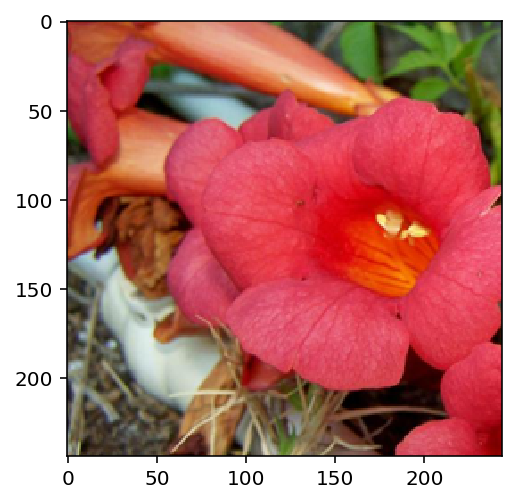

In [23]:
## Show an image
imshow(process_image("flowers/test/101/image_07952.jpg"));

To check the work, the function below converts a PyTorch tensor and displays it in the notebook. If the `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

## Class Prediction

Once images are in the correct format, it's time to write a function for making predictions with the model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes.Calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. Convert from these indices to the actual class labels using `class_to_idx` which was added to the model or from an `ImageFolder` that was used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so that we get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.


In [24]:
def predict(image_path, model, top_k=5):
    ''' use deep our model to Predict the class of an image. 
    
    image_path: Path to image (STRING) eg. "flowers/test/101/image_07952.jpg"
    model: pytorch neural network.
    top_k: integer. The top-K classes to be calculated; default value is 5
    
    returns top_probabilities(k), top_labels
    '''
    # CPU wors better so switch to CPU
    model.to("cpu")
    
    # Set model to evaluate
    model.eval();

    # Convert image from numpy to torch
    torch_image = torch.from_numpy(np.expand_dims(process_image(image_path), axis=0)).type(torch.FloatTensor).to("cpu")

    # Find probabilities (log softmax means that its on a log scale)
    log_probs = model.forward(torch_image)

    # Converting to linear scale
    linear_probs = torch.exp(log_probs)

    # Find the top 5 prediction by model
    top_guess, top_labels = linear_probs.topk(top_k)
    
    # Detatch the details
    top_guess = np.array(top_guess.detach())[0]
    top_labels = np.array(top_labels.detach())[0]
    
    # Convert to classes
    idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labels]
    top_flowers = [cat_to_name[lab] for lab in top_labels]
    
    return top_guess, top_labels, top_flowers
    

## Sanity Checking

Now we can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. 

convert from the class integer encoding to actual flower names with the `cat_to_name.json` file 

The given flower is  king protea . let's see what model predicts???


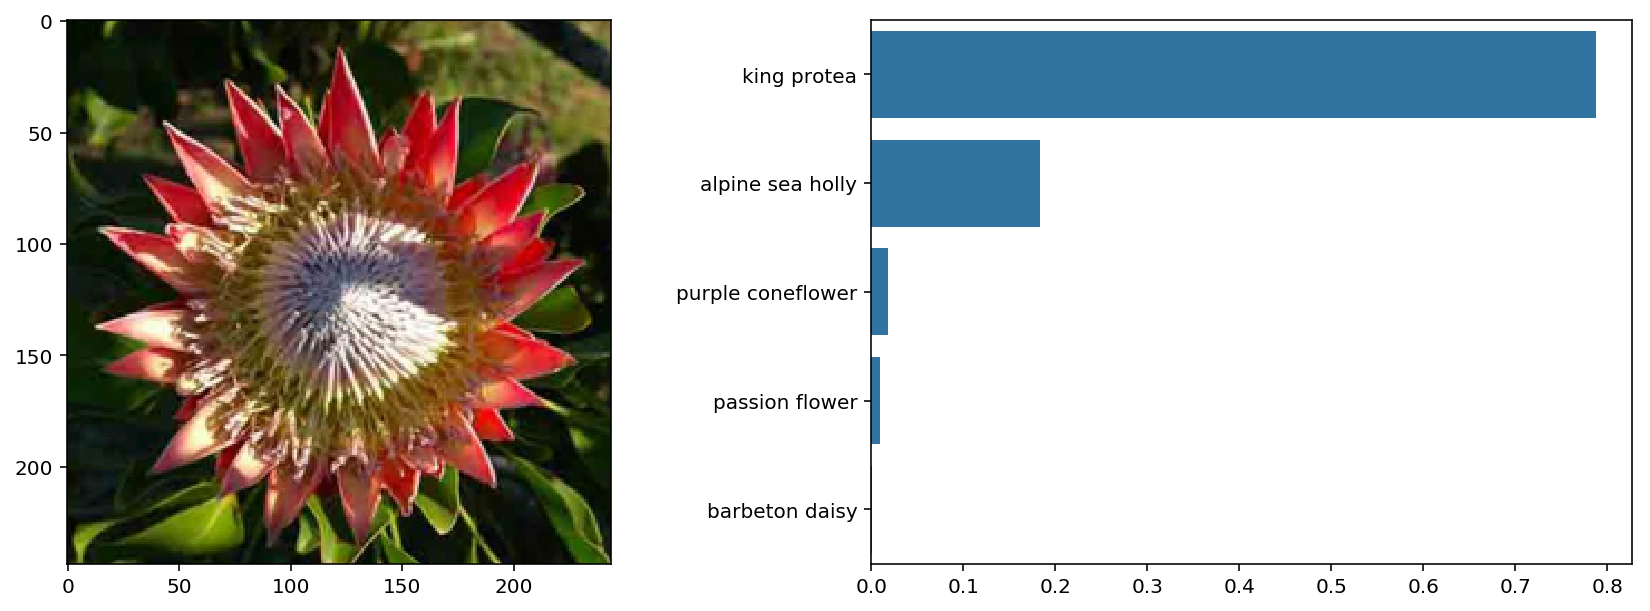

In [25]:
# TODO: Display an image along with the top 5 classes
# Define image including its path  
image_path = "flowers/test/13/image_05745.jpg"

plt.figure(figsize = (15,5))
ax = plt.subplot(1,2,1)

# Set up title
flower_num = image_path.split('/')[2]
title_ = cat_to_name[flower_num]
print("The given flower is ",title_, ". let's see what model predicts???")
# Plot flower
img = process_image(image_path)
imshow(img, ax) #, title = title_);

# Make prediction
probs, labs, flowers = predict(image_path, model) 


# Plot bar chart
plt.subplot(1,2,2)
sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
plt.show()

In [ ]:
### THE END